In [4]:
!which python

/opt/conda/bin/python


In [1]:
from pprint import pprint
import json

## Downloading Files from Bucket

In [2]:
import fsspec

mapper = fsspec.get_mapper('gcs://data-projectx/')

list(mapper)

['dem_suelo/Chile_DEM_0001x0001grad.tif',
 'dem_suelo/LC_CHILE_2014_b.tif',
 'dem_suelo/Valor_Usos_de_suelo.png',
 'gis/areas_pobladas/Areas_Pobladas.CPG',
 'gis/areas_pobladas/Areas_Pobladas.dbf',
 'gis/areas_pobladas/Areas_Pobladas.prj',
 'gis/areas_pobladas/Areas_Pobladas.sbn',
 'gis/areas_pobladas/Areas_Pobladas.sbx',
 'gis/areas_pobladas/Areas_Pobladas.shp',
 'gis/areas_pobladas/Areas_Pobladas.shp.xml',
 'gis/areas_pobladas/Areas_Pobladas.shx',
 'gis/estaciones/.DS_Store',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.dbf',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.prj',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.sbn',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.sbx',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.shp',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.shp.xml',
 'gis/estaciones/fluvio/Est_Fluviometricas_DGA_Vigentes.shx',
 'gis/estaciones/meteo/Est_Meteorologicas_DGA_Vigentes.dbf',
 'gis/estaciones/m

In [3]:
from io import StringIO
import pandas as pd

def read_bytes_string(byte_file, encoding='utf-8'):
    s = str(byte_file,'utf-8')
    return StringIO(s) 

ls_df = pd.read_csv(read_bytes_string(mapper['nasa/procesados/data_final.csv']))
ls_df.head(5)

,id,nearest_pl,landslide_,trigger,fatalities,injuries,location_a,landslide1,cat_src,cat_id,countrynam,near,distance,population,continentc,tstamp,changeset_,latitude,longitude,geometry
0,3177,Grove Street from Anderson Avenue to Hine Hill...,Mudslide,Downpour,0.0,0.0,Known_within_1_km,Medium,glc,3177.0,United States,New Milford,2.12825,6523.0,NaN,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1.000000e+00,41.5585,-73.4020,POINT (-73.402 41.5585)
1,490,"Borneo, Muara",Landslide,Rain,0.0,0.0,Unknown,Medium,glc,490.0,Indonesia,Longnawang,215.44888,0.0,AS,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1.000000e+00,0.1115,113.9171,POINT (113.917 0.1115)
2,6760,"Ocean Falls, B.C.",Mudslide,Rain,0.0,0.0,Known_within_1km,Medium,glc,6760.0,Canada,Kitimat,199.44893,8987.0,NaN,Tue Feb 17 2015 15:42:41 GMT+0000 (UTC),3.910847e+09,52.3545,-127.6980,POINT (-127.698 52.3545)
3,2494,"road to Holberg, 3 km from hwy 19, Vancouver I...",Complex,Downpour,0.0,0.0,Known_within_1_km,Medium,glc,2494.0,Canada,Campbell River,178.23706,33430.0,NaN,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1.000000e+00,50.7053,-127.5062,POINT (-127.506 50.7053)
4,6415,Rennell Sound Road,Mudslide,Downpour,0.0,0.0,Known_within_15km,Small,glc,6415.0,Canada,Prince Rupert,176.02202,14708.0,NaN,Thu Dec 04 2014 15:14:07 GMT+0000 (UTC),1.280292e+09,53.3319,-132.4149,POINT (-132.415 53.3319)


In [4]:
ls_df.columns

Index(['id', 'nearest_pl', 'landslide_', 'trigger', 'fatalities', 'injuries',
       'location_a', 'landslide1', 'cat_src', 'cat_id', 'countrynam', 'near',
       'distance', 'population', 'continentc', 'tstamp', 'changeset_',
       'latitude', 'longitude', 'geometry'],
      dtype='object')

### Need to preprocess-format

In [5]:
ls_df['landslide1'].unique()

array(['Medium', 'Small', 'Large', 'Very_large', 'unknown', 'large',
       'medium', 'small', 'Extra Large', nan], dtype=object)

## Creating Polygons

In [6]:
def create_Point(lat, lon, properties_dict, add_bbox=False):
    aoi_point = \
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [lon, lat]
      }
    }
    
    aoi_point['properties'] = properties_dict
    
    if add_bbox:
        bbox = create_bbox(lat, lon)
        aoi_point['bbox'] = bbox
        
    return aoi_point

def create_Collection(feature_list):
    
    aoi_point_collection = {
        "type": "FeatureCollection",
        "features": []
    }
    
    for feature in feature_list:
        aoi_point_collection["features"].append(feature)
    return aoi_point_collection

def create_landslides_nasa_points(df):

    from dateutil.parser import parse

    point_list = []

    for idx, row in df.iterrows():
        properties_dict = {}

        # properties
        properties_dict['location']  = row['nearest_pl']
        properties_dict['severity']  = row['landslide1']
        properties_dict['date']      = parse(row['tstamp']).strftime('%Y-%m-%d')
        properties_dict['kind' ]     = row['landslide_']
        properties_dict['trigger']   = row['trigger']
        properties_dict['fatalities']= row['fatalities']
        properties_dict['injuries']  = row['injuries']

        point_list.append(create_Point(lon=row['longitude'], lat=row['latitude'], properties_dict=properties_dict))
        
    return point_list

def create_Polygon_around_Point_v1(point):
    new_polygon = point
    new_polygon['geometry']['type'] = 'Polygon'
    lon, lat = new_polygon['geometry']['coordinates']
    
    new_coords = [
            [lon - 0.01, lat - 0.01], 
            [lon + 0.1, lat], 
            [lon + 0.1, lat + 0.1],
            [lon, lat + 0.1], 
            [lon - 0.01, lat - 0.01]
      ]
    new_polygon['geometry']['coordinates'] = new_coords
    
    return new_polygon

def create_Polygon_around_Point_v2(point, radius=1, square=False, return_shape=False):
    from shapely.geometry import Point
    
    lon, lat = point['geometry']['coordinates']
            
    polygon = Point(lon, lat).buffer(radius)
    
    if square:
        polygon = polygon.envelope
        
    if return_shape:
        return polygon
    
    point['geometry'] = polygon.__geo_interface__
    
    return point

## Intersecting with images

https://docs.descarteslabs.com/guides/catalog_v2.html

https://docs.descarteslabs.com/guides/scenes.html

In [12]:
import descarteslabs as dl

In [13]:
def date_interval(date, delta=1, return_str=False):
    from dateutil.relativedelta import relativedelta
    from dateutil.parser import parse
    
    if return_str:
        return (parse(date) - relativedelta(days=delta)).strftime('%Y-%m-%d'), (parse(date) + relativedelta(days=delta)).strftime('%Y-%m-%d')
    
    return parse(date) - relativedelta(days=delta), parse(date) + relativedelta(days=delta)

## Option 1 : Scene API

(-73.902, 41.0585, -72.902, 42.0585) [-73.402, 41.5585]


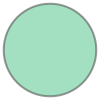

In [8]:
from shapely.geometry import Polygon, shape

# using deepcopy because we are changing a dict inside a list
# if this isn't a problem, we can avoid copying 
import copy

point_list = create_landslides_nasa_points(ls_df)

method = 2 # method to create polygon around a Point v1 or v2 
if method == 1:
    polygon_list = [create_Polygon_around_Point_v1(point) for point in copy.deepcopy(point_list)] 

    feature_collection = create_Collection(polygon_list)

    a_feature = feature_collection['features'][0]
    a_shape = Polygon(a_feature['geometry']['coordinates'])

elif method == 2:
    polygon_list = [create_Polygon_around_Point_v2(point, radius=0.5) for point in copy.deepcopy(point_list)] 

    feature_collection = create_Collection(polygon_list)

    a_feature = feature_collection['features'][0]
    a_shape = shape(a_feature['geometry'])
    
print(a_shape.bounds, point_list[0]['geometry']['coordinates'])
a_shape

In [14]:
def search_scenes(aoi, product_ids, mid_date=None, date_range=None, start_date=None, end_date=None, limit=10):
    if mid_date is not None and date_range is not None:
        start_date, end_date = date_interval(point_list[0]['properties']['date'], date_range)
        
    scenes, ctx = dl.scenes.search(
        aoi,
        products=product_ids,
        start_datetime=start_date,
        end_datetime=end_date,
        limit=limit
    )
    
    return scenes, ctx

scenes, ctx = search_scenes(
    aoi=a_shape, 
    product_ids=["landsat:LC08:PRE:TOAR"], 
    mid_date=point_list[0]['properties']['date'], 
    date_range=2
)

scenes

SceneCollection of 1 scene
  * Dates: Apr 01, 2014 to Apr 01, 2014
  * Products: landsat:LC08:PRE:TOAR: 1

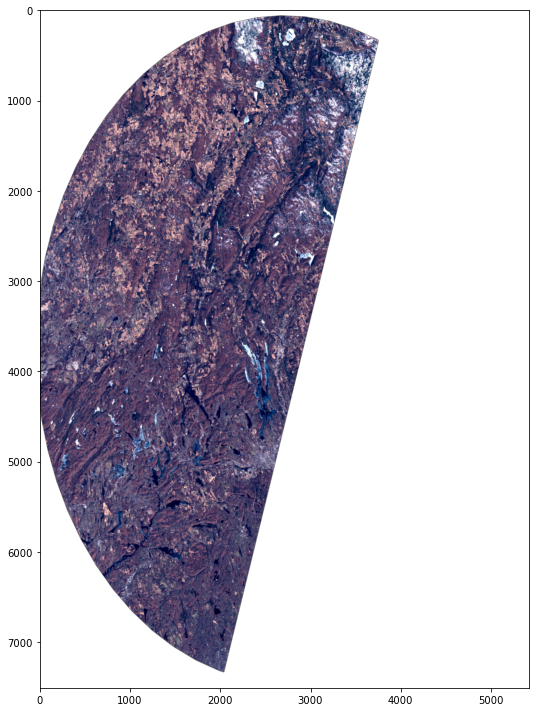

In [15]:
scene = scenes[-1]
ctx_lowres = ctx.assign(resolution=60)
arr = scene.ndarray("red green blue", ctx)
dl.scenes.display(arr)

## Option 2 : Catalog API (Not working/not understood yet)

https://docs.descarteslabs.com/examples-gallery/raster_mosaic.html

In [16]:
center_lon, center_lat = point_list[0]['geometry']['coordinates']

In [17]:
from descarteslabs.catalog import Image, properties as p
import matplotlib.pyplot as plt

In [18]:
raster_client = dl.Raster()

# Define my area of interest
tile = raster_client.dltile_from_latlon(
    center_lon, center_lat, resolution=100.0*5, tilesize=1024*10, pad=0
)

start_date, end_date = date_interval(point_list[0]['properties']['date'], 2)

# Search for Sentinel-2 imagery collected between
# August 13 - August 21, 2017 over the AOI
image_metadata = list(
    Image.search()
    .filter(p.product_id == "landsat:LC08:PRE:TOAR")
    .filter(start_date < p.acquired < end_date)
    .intersects(tile)
)

In [19]:
dates = list(set([image.acquired.date() for image in image_metadata]))

# mosaic the images acquired on each date
images = list()
for date in dates:
    # get ids
    ids = [image.id for image in image_metadata if image.acquired.date() == date]
    # retrieve mosaicked data
    arr, meta = raster_client.ndarray(
        ids,
        dltile=tile,
        bands=["red", "green", "blue"],
        scales=[[0, 6000, 0, 255], [0, 4000, 0, 255], [0, 4000, 0, 255]],
    )
    images.append(arr)

len(images), images[0].sum() != 0 # hay imagenes y las imagenes no estan vacias?

(3, True)

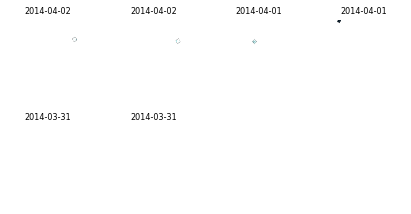

In [21]:
images = list()
for image in image_metadata:
    arr, meta = raster_client.ndarray(
        image.id,
        dltile=tile,
        bands=["nir", "red", "green", "alpha"],
        scales=[[0, 6000, 0, 255], [0, 4000, 0, 255], [0, 4000, 0, 255]],
        data_type="Byte",
    )
    images.append(arr)

# Plot using Matplotlib
fig = plt.figure(figsize=[6, 6])
for i, image in enumerate(images):
    # get acquisition date of the image
    date = image_metadata[i].acquired.date()

    # plot the image
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(image)
    ax.set_title(date, fontsize=8)
    plt.axis("off")

plt.tight_layout()

In [67]:
import numpy as np

np.array(arr)

array([[[14, 34, 62],
        [14, 35, 63],
        [14, 34, 62],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[14, 34, 62],
        [14, 34, 62],
        [14, 34, 63],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[14, 35, 63],
        [14, 34, 63],
        [14, 34, 63],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

## Geojson example

In [ ]:
a = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [102.0, 0.5]
      },
      "properties": {
        "prop0": "value0"
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [102.0, 0.0], [103.0, 1.0], [104.0, 0.0], [105.0, 1.0]
        ]
      },
      "properties": {
        "prop0": "value0",
        "prop1": 0.0
      }
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [100.0, 0.0], [101.0, 0.0], [101.0, 1.0],
            [100.0, 1.0], [100.0, 0.0]
          ]
        ]
      },
      "properties": {
        "prop0": "value0",
        "prop1": { "this": "that" }
      }
    }
  ]
}